### Implementation

In [1]:
import torch
import numpy as np
import copy
import os
from pathlib import Path
import cv2
import shutil

from demo import TrajCrafter
from models.utils import Warper, read_video_frames, sphere2pose, save_video
import torch.nn.functional as F
from tqdm import tqdm

from models.infer import DepthCrafterDemo

import os
from datetime import datetime
import torch
import copy
import time
import sys
import tempfile
from pathlib import Path

# Add core.py to path if needed
sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/28_08_25_trajectories')
from core import VisualizationWarper

sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/06_10_25_vggt')
from parsing import get_parser


class TrajCrafterAutoregressive(TrajCrafter):
    def __init__(self, opts):
        super().__init__(opts)

        # self.funwarp = VisualizationWarper(device=opts.device)
        self.prompt = None
        
        self.K = torch.tensor(
            [[500, 0.0, 512.], [0.0, 500, 288.], [0.0, 0.0, 1.0]]
            ).repeat(opts.video_length, 1, 1).to(opts.device)

/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
sys.argv = [
    "",
    "--video_path", "/home/azhuravl/nobackup/DAVIS_testing/trainval/rhino.mp4",
    "--n_splits", "2",
    "--overlap_frames", "0",
    "--radius", "0",
    "--mode", "gradual",
]

parser = get_parser()
opts_base = parser.parse_args()

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
video_basename = os.path.splitext(os.path.basename(opts_base.video_path))[0]

# Setup
opts_base.weight_dtype = torch.bfloat16
opts_base.exp_name = f"{video_basename}_{timestamp}_autoregressive"
opts_base.save_dir = os.path.join(opts_base.out_dir, opts_base.exp_name)

# Create TrajCrafterVisualization instance for autoregressive generation
radius = opts_base.radius

variants = [
    ("right_90", [0, 90, radius, 0, 0]),
]
name = "right_90"
pose = [0, 90, radius, 0, 0]

print(f"\n=== Running Autoregressive {name} ===")
opts = copy.deepcopy(opts_base)
opts.exp_name = f"{video_basename}_{timestamp}_{name}_auto_s{opts_base.n_splits}"
opts.save_dir = os.path.join(opts.out_dir, opts.exp_name)
opts.camera = "target"
opts.target_pose = pose
opts.traj_txt = 'test/trajs/loop2.txt'

# Make directories
os.makedirs(opts.save_dir, exist_ok=True)



=== Running Autoregressive right_90 ===


In [3]:


class TrajCrafterVisualization(TrajCrafter):
    """Lightweight TrajCrafter subclass for camera trajectory visualization"""
    
    def __init__(self, opts):
        # Only initialize what we need for pose generation and depth estimation
        self.device = opts.device
        self.depth_estimater = DepthCrafterDemo(
            unet_path=opts.unet_path,
            pre_train_path=opts.pre_train_path,
            cpu_offload=opts.cpu_offload,
            device=opts.device,
        )
        print("TrajCrafterVisualization initialized (diffusion pipeline skipped)")
    
    def extract_scene_data(self, opts):
        """Extract all data needed for 3D visualization"""
        print("Reading video frames...")
        frames = read_video_frames(
            opts.video_path, opts.video_length, opts.stride, opts.max_res
        )
        
        print("Estimating depth...")
        depths = self.depth_estimater.infer(
            frames,
            opts.near,
            opts.far,
            opts.depth_inference_steps,
            opts.depth_guidance_scale,
            window_size=opts.window_size,
            overlap=opts.overlap,
        ).to(opts.device)
        
        print("Converting frames to tensors...")
        frames_tensor = (
            torch.from_numpy(frames).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
        )
        
        print("Generating camera poses...")
        pose_s, pose_t, K = self.get_poses(opts, depths, num_frames=opts.video_length)
        
        # Calculate scene radius
        radius = (
            depths[0, 0, depths.shape[-2] // 2, depths.shape[-1] // 2].cpu()
            * opts.radius_scale
        )
        radius = min(radius, 5)
        
        return {
            'frames_numpy': frames,
            'frames_tensor': frames_tensor,
            'depths': depths,
            'pose_source': pose_s,
            'pose_target': pose_t,
            'intrinsics': K,
            'radius': radius,
            'trajectory_params': opts.target_pose if hasattr(opts, 'target_pose') else None
        }
        
    
    def infer_gradual(self, opts):
        frames = read_video_frames(
            opts.video_path, opts.video_length, opts.stride, opts.max_res
        )
        # depths= self.depth_estimater.infer(frames, opts.near, opts.far).to(opts.device)
        depths = self.depth_estimater.infer(
            frames,
            opts.near,
            opts.far,
            opts.depth_inference_steps,
            opts.depth_guidance_scale,
            window_size=opts.window_size,
            overlap=opts.overlap,
        ).to(opts.device)
        frames = (
            torch.from_numpy(frames).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
        )  # 49 576 1024 3 -> 49 3 576 1024, [-1,1]
        assert frames.shape[0] == opts.video_length
        pose_s, pose_t, K = self.get_poses(opts, depths, num_frames=opts.video_length)
        warped_images = []
        masks = []
        for i in tqdm(range(opts.video_length)):
            warped_frame2, mask2, warped_depth2, flow12 = self.funwarp.forward_warp(
                frames[i : i + 1],
                None,
                depths[i : i + 1],
                pose_s[i : i + 1],
                pose_t[i : i + 1],
                K[i : i + 1],
                None,
                opts.mask,
                twice=False,
            )
            warped_images.append(warped_frame2)
            masks.append(mask2)
        cond_video = (torch.cat(warped_images) + 1.0) / 2.0
        cond_masks = torch.cat(masks)

        frames = F.interpolate(
            frames, size=opts.sample_size, mode='bilinear', align_corners=False
        )
        cond_video = F.interpolate(
            cond_video, size=opts.sample_size, mode='bilinear', align_corners=False
        )
        cond_masks = F.interpolate(cond_masks, size=opts.sample_size, mode='nearest')
        save_video(
            (frames.permute(0, 2, 3, 1) + 1.0) / 2.0,
            os.path.join(opts.save_dir, 'input.mp4'),
            fps=opts.fps,
        )
        save_video(
            cond_video.permute(0, 2, 3, 1),
            os.path.join(opts.save_dir, 'render.mp4'),
            fps=opts.fps,
        )
        save_video(
            cond_masks.repeat(1, 3, 1, 1).permute(0, 2, 3, 1),
            os.path.join(opts.save_dir, 'mask.mp4'),
            fps=opts.fps,
        )

        frames = (frames.permute(1, 0, 2, 3).unsqueeze(0) + 1.0) / 2.0
        frames_ref = frames[:, :, :10, :, :]
        cond_video = cond_video.permute(1, 0, 2, 3).unsqueeze(0)
        cond_masks = (1.0 - cond_masks.permute(1, 0, 2, 3).unsqueeze(0)) * 255.0
        generator = torch.Generator(device=opts.device).manual_seed(opts.seed)

        return cond_video, cond_masks
        

In [4]:
vis_crafter = TrajCrafterAutoregressive(opts_base)

Expected types for unet: ['UNetSpatioTemporalConditionModel'], got DiffusersUNetSpatioTemporalConditionModelDepthCrafter.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:186: FutureWarning: `get_3d_sincos_pos_embed` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type='pt' to use the new version now.
  deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:304: FutureWarning: `get_2d_sincos_pos_embed_from_grid` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type='pt' to use the new version now.
  deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:337: FutureWarning: `get_1d_sincos_pos_embed_from_grid` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type=

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
import torch
import numpy as np
import copy

from demo import TrajCrafter
from models.utils import Warper, read_video_frames
from models.infer import DepthCrafterDemo
import inference_orbits


# Cell 3: Visualization Classes
class VisualizationWarper(Warper):
    """Extended Warper class for 3D visualization"""
    
    def extract_3d_points_with_colors(
        self,
        frame1: torch.Tensor,
        depth1: torch.Tensor,
        transformation1: torch.Tensor,
        intrinsic1: torch.Tensor,
        subsample_step: int = 10
    ):
        """Extract 3D world points and their corresponding colors for visualization"""
        b, c, h, w = frame1.shape
        
        # Move tensors to device
        frame1 = frame1.to(self.device).to(self.dtype)
        depth1 = depth1.to(self.device).to(self.dtype)
        transformation1 = transformation1.to(self.device).to(self.dtype)
        intrinsic1 = intrinsic1.to(self.device).to(self.dtype)
        
        # Create subsampled pixel coordinates for performance
        x_coords = torch.arange(0, w, subsample_step, dtype=torch.float32)
        y_coords = torch.arange(0, h, subsample_step, dtype=torch.float32)
        
        
        x2d, y2d = torch.meshgrid(x_coords, y_coords, indexing='xy')
        # x2d, y2d = torch.meshgrid(x_coords, y_coords, indexing='ij')
        x2d = x2d.to(depth1.device)
        y2d = y2d.to(depth1.device)
        ones_2d = torch.ones_like(x2d)
        
        # Stack into homogeneous coordinates
        pos_vectors_homo = torch.stack([x2d, y2d, ones_2d], dim=2)[None, :, :, :, None]
        
        # Subsample depth and colors
        depth_sub = depth1[:, 0, ::subsample_step, ::subsample_step]
        colors_sub = frame1[:, :, ::subsample_step, ::subsample_step]
        
        # Unproject to 3D camera coordinates
        intrinsic1_inv = torch.linalg.inv(intrinsic1)
        intrinsic1_inv_4d = intrinsic1_inv[:, None, None]
        depth_4d = depth_sub[:, :, :, None, None]
        
        unnormalized_pos = torch.matmul(intrinsic1_inv_4d, pos_vectors_homo)
        
        # print('depth_4d', depth_4d.shape)
        # print('unnormalized_pos', unnormalized_pos.shape)
        
        camera_points = depth_4d * unnormalized_pos
        
        # Transform to world coordinates
        ones_4d = torch.ones(b, camera_points.shape[1], camera_points.shape[2], 1, 1).to(depth1)
        world_points_homo = torch.cat([camera_points, ones_4d], dim=3)
        trans_4d = transformation1[:, None, None]
        world_points_homo = torch.matmul(trans_4d, world_points_homo)
        world_points = world_points_homo[:, :, :, :3, 0]  # (b, h_sub, w_sub, 3)
        
        # Prepare colors
        colors = colors_sub.permute(0, 2, 3, 1)  # (b, h_sub, w_sub, 3)
        
        # Filter valid points (positive depth)
        valid_mask = depth_sub > 0  # (b, h_sub, w_sub)
        
        # Flatten and filter
        points_3d = world_points[valid_mask]  # (N, 3)
        colors_rgb = colors[valid_mask]       # (N, 3)
        
        return points_3d, colors_rgb
    

    def render_pointcloud_native_v2(
        self,
        points_3d: torch.Tensor,
        colors_3d: torch.Tensor,
        transformation_target: torch.Tensor,
        intrinsic_target: torch.Tensor,
        image_size: tuple = (576, 1024),
        mask: bool = False
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Render point cloud by creating synthetic depth/frame and using forward_warp
        """
        
        print("using warper v2!!!")
        
        h, w = image_size
        b = transformation_target.shape[0]
        device = self.device
        
        # Create a synthetic source frame with our point cloud data
        source_frame = torch.full((b, 3, h, w), -1.0, device=device, dtype=self.dtype)
        source_depth = torch.zeros(b, 1, h, w, device=device, dtype=self.dtype)
        source_mask = torch.zeros(b, 1, h, w, device=device, dtype=self.dtype)
        
        # Project world points to source camera (identity transformation)
        identity_transform = torch.eye(4, device=device, dtype=self.dtype).unsqueeze(0).repeat(b, 1, 1)
        
        # Convert world points to camera coordinates for the source view
        ones = torch.ones(points_3d.shape[0], 1, device=device, dtype=self.dtype)
        world_points_homo = torch.cat([points_3d, ones], dim=1)
        
        # For source camera, we can use identity or extract the original transformation
        # Let's assume we're rendering from an identity camera position
        camera_points = points_3d  # For identity camera position
        
        # Project to 2D
        projected_homo = torch.matmul(intrinsic_target[0], camera_points.T).T
        pixel_coords = projected_homo[:, :2] / projected_homo[:, 2:3]
        depths_vals = camera_points[:, 2]
        
        # Filter valid points
        valid_mask = (depths_vals > 0.01) & \
                    (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < w) & \
                    (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < h)
        
        if valid_mask.sum() == 0:
            return (torch.full((b, 3, h, w), -1.0, device=device, dtype=self.dtype),
                    torch.zeros(b, 1, h, w, device=device, dtype=self.dtype))
        
        valid_coords = pixel_coords[valid_mask]
        valid_colors = colors_3d[valid_mask]
        valid_depths = depths_vals[valid_mask]
        
        # Fill source frame/depth with our data
        x_int = torch.clamp(torch.round(valid_coords[:, 0]).long(), 0, w-1)
        y_int = torch.clamp(torch.round(valid_coords[:, 1]).long(), 0, h-1)
        
        for i in range(len(x_int)):
            x, y = x_int[i], y_int[i]
            source_frame[0, :, y, x] = valid_colors[i]
            source_depth[0, 0, y, x] = valid_depths[i]
            source_mask[0, 0, y, x] = 1.0
        
        # Now use the warper's forward_warp method
        warped_frame, warped_mask, _, _ = self.forward_warp(
            source_frame,
            source_mask,
            source_depth,
            identity_transform,  # Source transformation (identity)
            transformation_target,  # Target transformation
            intrinsic_target,
            None,  # Use same intrinsics
            mask=mask,
            twice=False
        )
        
        print(f"Final warped range: [{warped_frame.min():.3f}, {warped_frame.max():.3f}]")
        print(f"Valid pixels: {warped_mask.sum().item()}")
        
        return warped_frame, warped_mask


In [234]:
from typing import Optional, Tuple

class GlobalPointCloudWarper(Warper):
    def __init__(self, resolution: tuple = None, device: str = 'cuda', max_points: int = 1000000):
        super().__init__(resolution, device)
        self.max_points = max_points
        self.reset_pointcloud()
        
        self.device = device
    
    def reset_pointcloud(self):
        """Reset the global point cloud"""
        self.global_points = None  # (N, 3) world coordinates
        self.global_colors = None  # (N, 3) RGB colors
        self.global_weights = None  # (N, 1) confidence weights
        self.point_count = 0
    
    def lift_to_3d_pointcloud(
        self,
        frame1: torch.Tensor,
        mask1: Optional[torch.Tensor],
        depth1: torch.Tensor,
        transformation1: torch.Tensor,
        intrinsic1: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Lift 2D image points to 3D world coordinates with colors.
        """
        if self.resolution is not None:
            assert frame1.shape[2:4] == self.resolution
        b, c, h, w = frame1.shape
        if mask1 is None:
            mask1 = torch.ones(size=(b, 1, h, w), device=self.device, dtype=self.dtype)

        # Move tensors to device and convert to proper dtype
        frame1 = frame1.to(self.device).to(self.dtype)
        mask1 = mask1.to(self.device).to(self.dtype)
        depth1 = depth1.to(self.device).to(self.dtype)
        transformation1 = transformation1.to(self.device).to(self.dtype)
        intrinsic1 = intrinsic1.to(self.device).to(self.dtype)

        # Create pixel coordinates directly on device
        x1d = torch.arange(0, w, device=self.device, dtype=self.dtype)[None]
        y1d = torch.arange(0, h, device=self.device, dtype=self.dtype)[:, None]
        x2d = x1d.repeat([h, 1])  # (h, w)
        y2d = y1d.repeat([1, w])  # (h, w)
        ones_2d = torch.ones(size=(h, w), device=self.device, dtype=self.dtype)  # (h, w)
        
        pos_vectors_homo = torch.stack([x2d, y2d, ones_2d], dim=2)[
            None, :, :, :, None
        ]  # (1, h, w, 3, 1)

        # Rest of the function remains the same...
        intrinsic1_inv = torch.linalg.inv(intrinsic1)  # (b, 3, 3)
        intrinsic1_inv_4d = intrinsic1_inv[:, None, None]  # (b, 1, 1, 3, 3)
        depth_4d = depth1[:, 0][:, :, :, None, None]  # (b, h, w, 1, 1)

        unnormalized_pos = torch.matmul(
            intrinsic1_inv_4d, pos_vectors_homo
        )  # (b, h, w, 3, 1)
        
        # Get 3D points in camera coordinate system
        camera_points = depth_4d * unnormalized_pos  # (b, h, w, 3, 1)
        
        # Transform to world coordinates
        ones_4d = torch.ones(size=(b, h, w, 1, 1), device=self.device, dtype=self.dtype)
        camera_points_homo = torch.cat([camera_points, ones_4d], dim=3)  # (b, h, w, 4, 1)
        
        # Apply inverse transformation to get world coordinates
        transformation1_inv = torch.linalg.inv(transformation1)  # (b, 4, 4)
        transformation1_inv_4d = transformation1_inv[:, None, None]  # (b, 1, 1, 4, 4)
        world_points_homo = torch.matmul(transformation1_inv_4d, camera_points_homo)  # (b, h, w, 4, 1)
        world_points = world_points_homo[:, :, :, :3, 0]  # (b, h, w, 3)
        
        # Get colors (convert from channel-first to spatial layout)
        colors = frame1.permute(0, 2, 3, 1)  # (b, h, w, 3)
        
        # Apply mask to filter out invalid points
        valid_mask = mask1[:, 0, :, :].unsqueeze(-1)  # (b, h, w, 1)
        world_points = world_points * valid_mask
        colors = colors * valid_mask
        
        return world_points, colors

    def update_pointcloud_from_image(
        self,
        frame: torch.Tensor,
        mask: Optional[torch.Tensor],
        depth: torch.Tensor,
        transformation: torch.Tensor,
        intrinsic: torch.Tensor,
        confidence_weight: float = 1.0
    ):
        """Add points from a new source image to the global point cloud"""
        # Ensure all inputs are on the correct device
        frame = frame.to(self.device).to(self.dtype)
        depth = depth.to(self.device).to(self.dtype)
        transformation = transformation.to(self.device).to(self.dtype)
        intrinsic = intrinsic.to(self.device).to(self.dtype)
        
        if mask is not None:
            mask = mask.to(self.device).to(self.dtype)
        
        # Lift 2D points to 3D world coordinates
        world_points, colors = self.lift_to_3d_pointcloud(
            frame, mask, depth, transformation, intrinsic
        )
        
        # Flatten to point cloud format
        b, h, w, _ = world_points.shape
        if mask is None:
            mask = torch.ones(b, 1, h, w, device=self.device, dtype=self.dtype)
            
        # Only keep valid points
        valid_mask = mask[:, 0, :, :].bool()  # (b, h, w)
        
        new_points = world_points[valid_mask]  # (N_valid, 3)
        new_colors = colors[valid_mask]  # (N_valid, 3)
        new_weights = torch.full(
            (new_points.shape[0], 1), 
            confidence_weight, 
            device=self.device, 
            dtype=self.dtype
        )
        
        if self.global_points is None:
            # First point cloud - ensure on correct device
            self.global_points = new_points
            self.global_colors = new_colors
            self.global_weights = new_weights
        else:
            # Merge with existing point cloud
            self.global_points = torch.cat([self.global_points, new_points], dim=0)
            self.global_colors = torch.cat([self.global_colors, new_colors], dim=0)
            self.global_weights = torch.cat([self.global_weights, new_weights], dim=0)
            
            # Optional: Remove points that are too close (deduplication)
            # self._deduplicate_points(distance_threshold=0.01)
            
        self.point_count = self.global_points.shape[0]
        
        # Optional: Limit point cloud size
        if self.point_count > self.max_points:
            self._downsample_pointcloud()
    
    def _deduplicate_points(self, distance_threshold: float = 0.01):
        """Remove points that are very close to each other"""
        if self.point_count < 2:
            return
            
        # Simple deduplication - could be optimized with KD-tree for large clouds
        distances = torch.cdist(self.global_points, self.global_points)
        
        # Find pairs that are too close
        close_pairs = torch.triu(distances < distance_threshold, diagonal=1)
        indices_to_remove = torch.any(close_pairs, dim=0)
        
        # Keep points that are not too close to others
        keep_mask = ~indices_to_remove
        self.global_points = self.global_points[keep_mask]
        self.global_colors = self.global_colors[keep_mask]
        self.global_weights = self.global_weights[keep_mask]
    
    def _downsample_pointcloud(self):
        """Randomly downsample point cloud to max_points"""
        if self.point_count <= self.max_points:
            return
            
        # Random sampling weighted by confidence
        probabilities = (self.global_weights / self.global_weights.sum()).squeeze()
        indices = torch.multinomial(probabilities, self.max_points, replacement=False)
        
        self.global_points = self.global_points[indices]
        self.global_colors = self.global_colors[indices]
        self.global_weights = self.global_weights[indices]
    
    def render_from_camera(
        self,
        transformation: torch.Tensor,
        intrinsic: torch.Tensor,
        target_height: int,
        target_width: int,
        depth_threshold: float = 100000.0
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Render the global point cloud from a target camera viewpoint
        
        :param transformation: (b, 4, 4) target camera extrinsic matrix
        :param intrinsic: (b, 3, 3) target camera intrinsic matrix
        :param target_height: output image height
        :param target_width: output image width
        :param depth_threshold: maximum depth to render
        :return: rendered_image: (b, 3, h, w), mask: (b, 1, h, w)
        """
        if self.global_points is None or self.point_count == 0:
            b = transformation.shape[0]
            return (
                torch.zeros(b, 3, target_height, target_width, device=self.device),
                torch.zeros(b, 1, target_height, target_width, device=self.device)
            )
        
        b = transformation.shape[0]
        
        # Transform world points to camera coordinates
        points_homo = torch.cat([
            self.global_points, 
            torch.ones(self.point_count, 1, device=self.device)
        ], dim=1)  # (N, 4)
        
        # Apply transformation for each batch item
        rendered_images = []
        rendered_masks = []
        
        for batch_idx in range(b):
            # Transform to camera space
            camera_points_homo = torch.matmul(
                transformation[batch_idx], points_homo.T
            ).T  # (N, 4)
            camera_points = camera_points_homo[:, :3]  # (N, 3)
            
            # Filter points behind camera and too far
            valid_depth = (camera_points[:, 2] > 0.1) & (camera_points[:, 2] < depth_threshold)
            valid_points = camera_points[valid_depth]
            valid_colors = self.global_colors[valid_depth]
            valid_weights = self.global_weights[valid_depth]
            
            if valid_points.shape[0] == 0:
                rendered_images.append(torch.zeros(3, target_height, target_width, device=self.device))
                rendered_masks.append(torch.zeros(1, target_height, target_width, device=self.device))
                continue
            
            # Project to 2D
            projected = torch.matmul(intrinsic[batch_idx], valid_points.T).T  # (N, 3)
            pixel_coords = projected[:, :2] / projected[:, 2:3]  # (N, 2)
            depths = projected[:, 2]  # (N,)
            
            # Filter points outside image bounds
            in_bounds = (
                (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < target_width) &
                (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < target_height)
            )
            
            final_coords = pixel_coords[in_bounds]
            final_colors = valid_colors[in_bounds]
            final_depths = depths[in_bounds]
            final_weights = valid_weights[in_bounds]
            
            # Render using splatting (simplified version)
            rendered_image, rendered_mask = self._splat_points_to_image(
                final_coords, final_colors, final_depths, final_weights,
                target_height, target_width
            )
            
            rendered_images.append(rendered_image)
            rendered_masks.append(rendered_mask)
        
        return (
            torch.stack(rendered_images, dim=0),
            torch.stack(rendered_masks, dim=0)
        )
    
    def _splat_points_to_image(
        self,
        coords: torch.Tensor,  # (N, 2)
        colors: torch.Tensor,  # (N, 3)
        depths: torch.Tensor,  # (N,)
        weights: torch.Tensor,  # (N, 1)
        height: int,
        width: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Splat points into image using depth-weighted averaging"""
        
        if coords.shape[0] == 0:
            return (
                torch.zeros(3, height, width, device=self.device),
                torch.zeros(1, height, width, device=self.device)
            )
        
        # Initialize output buffers
        color_buffer = torch.zeros(3, height, width, device=self.device)
        weight_buffer = torch.zeros(1, height, width, device=self.device)
        
        # Convert to integer coordinates
        pixel_x = torch.clamp(coords[:, 0].round().long(), 0, width - 1)
        pixel_y = torch.clamp(coords[:, 1].round().long(), 0, height - 1)
        
        # Depth-based weights (closer points have higher weight)
        depth_weights = 1.0 / (depths + 1e-6)
        total_weights = weights.squeeze() * depth_weights
        
        # Accumulate colors and weights
        for i in range(coords.shape[0]):
            x, y = pixel_x[i], pixel_y[i]
            w = total_weights[i]
            color_buffer[:, y, x] += colors[i] * w
            weight_buffer[0, y, x] += w
        
        # Normalize by accumulated weights
        mask = weight_buffer > 0
        color_buffer = torch.where(
            mask.expand_as(color_buffer),
            color_buffer / weight_buffer.expand_as(color_buffer),
            torch.zeros_like(color_buffer)
        )
        
        return color_buffer, mask.float()

    def get_pointcloud_stats(self):
        """Return statistics about the current point cloud"""
        if self.global_points is None:
            return {"point_count": 0}
        
        return {
            "point_count": self.point_count,
            "bbox_min": self.global_points.min(dim=0).values.cpu().numpy(),
            "bbox_max": self.global_points.max(dim=0).values.cpu().numpy(),
            "mean_color": self.global_colors.mean(dim=0).cpu().numpy()
        }
        
    def _splat_points_to_image_optimized(
        self,
        coords: torch.Tensor,  # (N, 2)
        colors: torch.Tensor,  # (N, 3)
        depths: torch.Tensor,  # (N,)
        weights: torch.Tensor,  # (N, 1)
        height: int,
        width: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """GPU-optimized point splatting using scatter operations"""
        
        if coords.shape[0] == 0:
            return (
                torch.zeros(3, height, width, device=self.device),
                torch.zeros(1, height, width, device=self.device)
            )
        
        N = coords.shape[0]
        
        # Improved depth weighting (vectorized)
        normalized_depths = depths / (depths.max() + 1e-8)
        depth_weights = torch.exp(-normalized_depths * 2)
        total_weights = weights.squeeze() * depth_weights
        
        # Get integer pixel coordinates
        pixel_coords = torch.round(coords).long()
        
        # Filter out-of-bounds points
        valid_mask = (
            (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < width) &
            (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < height)
        )
        
        if not valid_mask.any():
            return (
                torch.zeros(3, height, width, device=self.device),
                torch.zeros(1, height, width, device=self.device)
            )
        
        # Filter valid points
        valid_coords = pixel_coords[valid_mask]
        valid_colors = colors[valid_mask]
        valid_depths = depths[valid_mask]
        valid_weights = total_weights[valid_mask]
        
        # Convert 2D coordinates to 1D indices
        linear_indices = valid_coords[:, 1] * width + valid_coords[:, 0]
        
        # Use scatter operations for GPU-efficient accumulation
        color_buffer = torch.zeros(3, height * width, device=self.device)
        weight_buffer = torch.zeros(height * width, device=self.device)
        
        # Scatter add colors and weights (vectorized)
        weighted_colors = valid_colors.T * valid_weights  # (3, N)
        
        for c in range(3):
            color_buffer[c].scatter_add_(0, linear_indices, weighted_colors[c])
        
        weight_buffer.scatter_add_(0, linear_indices, valid_weights)
        
        # Normalize colors where weights > 0
        valid_pixels = weight_buffer > 1e-6
        color_buffer[:, valid_pixels] /= weight_buffer[valid_pixels]
        
        # Reshape back to 2D
        color_image = color_buffer.view(3, height, width)
        mask_image = (weight_buffer > 1e-6).float().view(1, height, width)
        
        return color_image, mask_image

    def _splat_points_with_bilinear_optimized(
        self,
        coords: torch.Tensor,  # (N, 2)
        colors: torch.Tensor,  # (N, 3)
        depths: torch.Tensor,  # (N,)
        weights: torch.Tensor,  # (N, 1)
        height: int,
        width: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """GPU-optimized bilinear splatting"""
        
        if coords.shape[0] == 0:
            return (
                torch.zeros(3, height, width, device=self.device),
                torch.zeros(1, height, width, device=self.device)
            )
        
        # Depth weighting
        normalized_depths = depths / (depths.max() + 1e-8)
        depth_weights = torch.exp(-normalized_depths * 2)
        point_weights = weights.squeeze() * depth_weights
        
        # Bilinear interpolation coordinates
        coords_floor = torch.floor(coords)
        alpha = coords - coords_floor
        
        # Four corner coordinates
        x0, y0 = coords_floor[:, 0].long(), coords_floor[:, 1].long()
        x1, y1 = x0 + 1, y0 + 1
        
        # Bilinear weights
        w00 = (1 - alpha[:, 0]) * (1 - alpha[:, 1]) * point_weights
        w10 = alpha[:, 0] * (1 - alpha[:, 1]) * point_weights
        w01 = (1 - alpha[:, 0]) * alpha[:, 1] * point_weights
        w11 = alpha[:, 0] * alpha[:, 1] * point_weights
        
        # Collect all coordinates and weights
        all_x = torch.cat([x0, x1, x0, x1])
        all_y = torch.cat([y0, y0, y1, y1])
        all_weights = torch.cat([w00, w10, w01, w11])
        all_colors = torch.cat([colors, colors, colors, colors], dim=0)
        
        # Filter valid coordinates
        valid_mask = (
            (all_x >= 0) & (all_x < width) &
            (all_y >= 0) & (all_y < height) &
            (all_weights > 1e-6)
        )
        
        if not valid_mask.any():
            return (
                torch.zeros(3, height, width, device=self.device),
                torch.zeros(1, height, width, device=self.device)
            )
        
        # Filter and convert to linear indices
        valid_x = all_x[valid_mask]
        valid_y = all_y[valid_mask]
        valid_weights = all_weights[valid_mask]
        valid_colors = all_colors[valid_mask]
        
        linear_indices = valid_y * width + valid_x
        
        # Scatter operations
        color_buffer = torch.zeros(3, height * width, device=self.device)
        weight_buffer = torch.zeros(height * width, device=self.device)
        
        weighted_colors = valid_colors.T * valid_weights
        
        for c in range(3):
            color_buffer[c].scatter_add_(0, linear_indices, weighted_colors[c])
        
        weight_buffer.scatter_add_(0, linear_indices, valid_weights)
        
        # Normalize
        valid_pixels = weight_buffer > 1e-6
        color_buffer[:, valid_pixels] /= weight_buffer[valid_pixels]
        
        # Reshape
        color_image = color_buffer.view(3, height, width)
        mask_image = valid_pixels.float().view(1, height, width)
        
        return color_image, mask_image

    # For extremely large point clouds, use this approach:
    def render_from_camera_batched(
        self,
        transformation: torch.Tensor,
        intrinsic: torch.Tensor,
        target_height: int,
        target_width: int,
        batch_size: int = 50000,  # Process points in batches
        depth_threshold: float = 100000.0
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Render large point clouds in batches to avoid memory issues"""
        
        if self.global_points is None or self.point_count == 0:
            b = transformation.shape[0]
            return (
                torch.zeros(b, 3, target_height, target_width, device=self.device),
                torch.zeros(b, 1, target_height, target_width, device=self.device)
            )
        
        b = transformation.shape[0]
        transformation = transformation.to(self.device)
        intrinsic = intrinsic.to(self.device)
        
        rendered_images = []
        rendered_masks = []
        
        for batch_idx in range(b):
            # Initialize accumulation buffers
            final_color = torch.zeros(3, target_height, target_width, device=self.device)
            final_weight = torch.zeros(1, target_height, target_width, device=self.device)
            
            # Process points in batches
            num_batches = (self.point_count + batch_size - 1) // batch_size
            
            for i in range(num_batches):
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, self.point_count)
                
                # Get batch of points
                batch_points = self.global_points[start_idx:end_idx]
                batch_colors = self.global_colors[start_idx:end_idx]
                batch_weights = self.global_weights[start_idx:end_idx]
                
                # Transform batch
                points_homo = torch.cat([
                    batch_points, 
                    torch.ones(batch_points.shape[0], 1, device=self.device)
                ], dim=1)
                
                camera_points = torch.matmul(transformation[batch_idx], points_homo.T).T[:, :3]
                
                # Filter and project batch
                valid_depth = (camera_points[:, 2] > 0.01) & (camera_points[:, 2] < depth_threshold)
                if not valid_depth.any():
                    continue
                    
                valid_points = camera_points[valid_depth]
                valid_colors = batch_colors[valid_depth]
                valid_weights = batch_weights[valid_depth]
                
                projected = torch.matmul(intrinsic[batch_idx], valid_points.T).T
                pixel_coords = projected[:, :2] / projected[:, 2:3]
                depths = projected[:, 2]
                
                # Render batch
                batch_color, batch_mask = self._splat_points_with_bilinear_optimized(
                    pixel_coords, valid_colors, depths, valid_weights,
                    target_height, target_width
                )
                
                # Accumulate results
                final_color += batch_color * batch_mask
                final_weight += batch_mask
            
            # Final normalization
            valid_pixels = final_weight > 1e-6
            final_color = torch.where(
                valid_pixels.expand_as(final_color),
                final_color / final_weight.expand_as(final_color),
                final_color
            )
            
            rendered_images.append(final_color)
            rendered_masks.append((final_weight > 1e-6).float())
        
        return torch.stack(rendered_images), torch.stack(rendered_masks)

In [243]:
funwarp.global_weights.shape
# # check if all are 1
# torch.unique(funwarp.global_weights)

torch.Size([589824, 1])

In [235]:
# funwarp = VisualizationWarper(device=opts.device)
funwarp = GlobalPointCloudWarper(device=opts.device, max_points=2000000)

In [7]:
# ============================================================================
# UTILITY FUNCTIONS (moved outside class)
# ============================================================================

def pad_video(frames, target_length):
    if frames.shape[0] < target_length:
        last_frame = frames[-1:]
        num_pad = target_length - frames.shape[0]
        pad_frames = np.repeat(last_frame, num_pad, axis=0)
        frames = np.concatenate([frames, pad_frames], axis=0)
    return frames


def generate_traj_specified(c2ws_anchor, target_pose, n_frames, device):
    theta, phi, d_r, d_x, d_y = target_pose
    
    thetas = np.linspace(0, theta, n_frames)  
    phis = np.linspace(0, phi, n_frames)          
    rs = np.linspace(0, d_r, n_frames)            
    xs = np.linspace(0, d_x, n_frames)            
    ys = np.linspace(0, d_y, n_frames)            
    
    c2ws_list = []
    for th, ph, r, x, y in zip(thetas, phis, rs, xs, ys):
        c2w_new = sphere2pose(
            c2ws_anchor,
            np.float32(th),
            np.float32(ph),
            np.float32(r),
            device,
            np.float32(x),
            np.float32(y),
        )
        c2ws_list.append(c2w_new)
    c2ws = torch.cat(c2ws_list, dim=0)
    return c2ws


def save_poses_torch(c2ws, filepath):
    """Save camera poses as PyTorch tensor (.pth file)"""
    torch.save(c2ws.cpu(), filepath)

def save_point_clouds_torch(pc_list, color_list, dirpath):
    """Save point clouds as PyTorch tensors (much faster than text files)"""
    os.makedirs(dirpath, exist_ok=True)
    
    # Save as individual tensor files
    for idx, (pc, color) in enumerate(zip(pc_list, color_list)):
        # Save points and colors as separate tensors
        torch.save(pc.cpu(), os.path.join(dirpath, f'points_{idx:03d}.pth'))
        torch.save(color.cpu(), os.path.join(dirpath, f'colors_{idx:03d}.pth'))
    

def save_segment_results(pc_input, color_input, pc_inpainted, color_inpainted, 
                        pc_merged, color_merged, traj_segment, opts, segment_idx):
    # Function to save results for each segment
    # Implementation needed
    stage_dir = Path(opts.save_dir) / f'stage_{segment_idx+1}'
    stage_dir.mkdir(parents=True, exist_ok=True)
    

    save_point_clouds_torch(pc_input, color_input, stage_dir / 'point_cloud_input')
    # save_point_clouds_torch(pc_inpainted, color_inpainted, stage_dir / 'point_cloud_inpainted')
    # save_point_clouds_torch(pc_merged, color_merged, stage_dir / 'point_cloud_merged')
    save_poses_torch(traj_segment, stage_dir / 'cameras_target.pth')



In [ ]:
# read input video
frames = read_video_frames(
    opts.video_path, opts.video_length, opts.stride, opts.max_res
)

# pad if too short
frames = pad_video(frames, opts.video_length)

# prompt
vis_crafter.prompt = vis_crafter.get_caption(opts, frames[opts.video_length // 2])

==> processing video:  /home/azhuravl/nobackup/DAVIS_testing/trainval/rhino.mp4
==> original video shape:  (90, 480, 854, 3)
==> downsampled shape: (90, 576, 1024, 3), with stride: 1
==> final processing shape: (49, 576, 1024, 3)


In [ ]:
############################################
# Input Depth
############################################

depths = vis_crafter.depth_estimater.infer(
    frames,
    opts.near,
    opts.far,
    opts.depth_inference_steps,
    opts.depth_guidance_scale,
    window_size=opts.window_size,
    overlap=opts.overlap,
).to(opts.device)

Elapsed time for encoding video: 23784.69921875 ms


  0%|          | 0/5 [00:00<?, ?it/s]

Elapsed time for denoising video: 30614.26953125 ms
Elapsed time for decoding video: 7314.1943359375 ms


In [ ]:
##########################################
# Cameras
##########################################

radius = (
    depths[0, 0, depths.shape[-2] // 2, depths.shape[-1] // 2].cpu()
    * opts.radius_scale
)
radius = min(radius, 5)


c2ws_anchor = torch.tensor([ 
            [-1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, -1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
    ]).unsqueeze(0).to(opts.device)

c2ws_target = generate_traj_specified(
    c2ws_anchor, 
    opts.target_pose, 
    opts.video_length * opts.n_splits, 
    opts.device
)
c2ws_target[:, 2, 3] += radius

c2ws_init = c2ws_target[0].repeat(opts.video_length, 1, 1)


In [239]:
i = 0

funwarp.reset_pointcloud()

with torch.no_grad():
    funwarp.update_pointcloud_from_image(
        frames_tensor[i:i+1],
        None,
        depths[i:i+1] + 1e-4,
        c2ws_init[i:i+1],
        vis_crafter.K[i:i+1],
        1,
    )

In [226]:
target_image, target_mask = funwarp.render_from_camera_batched(
    c2ws_target[30:31],
    vis_crafter.K[0:1].to(opts.device),
    576, 1024
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.9604645e-08..1.0].


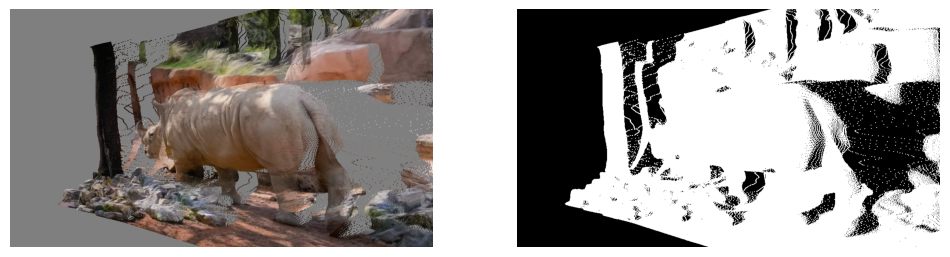

In [227]:
# plot the result
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

plt.imshow((target_image[0].permute(1,2,0).cpu().numpy() + 1) / 2)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(target_mask[0,0].cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [140]:
import viser
import numpy as np

# Start viser server
# server = viser.ViserServer()

server.scene.reset()

# Convert to numpy (assuming your global points are on GPU)
points_np = funwarp.global_points.cpu().numpy()  # (N, 3)
colors_np = funwarp.global_colors.cpu().numpy()  # (N, 3)

# Ensure colors are in [0, 1] range
colors_np = np.clip(colors_np, 0, 1)

# Add point cloud to viser
server.scene.add_point_cloud(
    name="global_pointcloud",
    points=points_np,
    colors=colors_np,
    point_size=0.01
)

pose = np.linalg.inv(c2ws_target[50].cpu().numpy())
position = pose[:3, 3]
rotation_matrix = pose[:3, :3]

# Convert rotation to quaternion
wxyz = viser.transforms.SO3.from_matrix(rotation_matrix).wxyz
server.scene.add_camera_frustum(
    f"/source_camera_{i}",
    fov=60, aspect=4/3, scale=0.08,  # Smaller scale
    position=position, wxyz=wxyz,
    color=(0.2, 0.8, 0.2)  # Light green
)

print(f"Visualizing {len(points_np)} points at http://localhost:8080")

Visualizing 589824 points at http://localhost:8080


In [142]:
import numpy as np

# Set camera pose
camera_pose = np.linalg.inv(c2ws_target[50].cpu().numpy())  # Your 4x4 camera pose matrix
position = camera_pose[:3, 3]
rotation_matrix = camera_pose[:3, :3]
wxyz = viser.transforms.SO3.from_matrix(rotation_matrix).wxyz

# Render image from camera viewpoint
rendered_image = server.scene.render_image(
    camera_position=position,
    camera_wxyz=wxyz,
    width=1024,
    height=576,
    fov=60.0
)

# Convert to numpy array for display
image_np = np.array(rendered_image)

# Display with matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(image_np)
plt.axis('off')
plt.title("Rendered from target camera")
plt.show()

AttributeError: 'SceneApi' object has no attribute 'render_image'

In [ ]:
traj_segments.shape

In [13]:
frames_tensor = (
    torch.from_numpy(frames).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
)  # 49 576 1024 3 -> 49 3 576 1024, [-1,1]
assert frames.shape[0] == opts.video_length



pc_list = []
color_list = []
for i in range(opts.video_length):
    
    # print(frames[i:i+1].shape)
    # print(depths[i:i+1].shape)
    
    pc, color = funwarp.extract_3d_points_with_colors(
        frames_tensor[i:i+1],
        depths[i:i+1],
        c2ws_init[i:i+1],
        vis_crafter.K[i:i+1],
        subsample_step=1
    )
    # print(pc.device)
    # print(color.device)
    pc_list.append(pc)
    color_list.append(color)


In [14]:
pc_list[0].shape, color_list[0].shape

(torch.Size([589824, 3]), torch.Size([589824, 3]))

In [24]:
########################################################
# Camera Pose Planning
########################################################
        
c2ws_target = generate_traj_specified(
    c2ws_init[0:1], 
    opts.target_pose, 
    opts.video_length * opts.n_splits, 
    opts.device
)

# c2ws_target[:, 2, 3] = c2ws_target[:, 2, 3] + radius

# take inverse
# c2ws_target = torch.inverse(c2ws_target)

# split into segments
traj_segments = c2ws_target.view(opts.n_splits, opts.video_length, 4, 4)


In [ ]:
# frames = (
#     torch.from_numpy(frames).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
# )  # 49 576 1024 3 -> 49 3 576 1024, [-1,1]
# assert frames.shape[0] == opts.video_length

# render the point clouds
warped_images = []
masks = []        
for i in tqdm(range(opts.video_length)):
    
    # print(pc_input[i].device)
    # print(color_input[i].device)
    # print(traj_segment[i:i+1].device)
    # print(vis_crafter.K[i:i+1].device)
    
    output_frame, output_mask = funwarp.render_pointcloud_native_v2(
        pc_input[i],
        color_input[i],
        traj_segment[i:i+1],
        vis_crafter.K[i:i+1],
        image_size=(576, 1024),
        mask=opts.mask,
    )
    warped_images.append(output_frame)
    masks.append(output_mask)
    
    # print(color_input)
    
# plot warped images 0, 10, 20
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, figsize=(20, 6))

# torch.Size([1, 3, 576, 1024]) torch.Size([1, 1, 576, 1024])

# print(warped_images.min(), warped_images.max())
# print(warped_images)

# print(warped_images[0].shape, masks[0].shape)
axs[0].imshow((frames[30].permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0)
axs[1].imshow((warped_images[30][0].permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0)
axs[2].imshow(masks[30][0].permute(1, 2, 0).cpu().numpy())

plt.show()


In [ ]:
cond_video = (torch.cat(warped_images) + 1.0) / 2.0
cond_masks = torch.cat(masks)

frames = F.interpolate(
    frames, size=opts.sample_size, mode='bilinear', align_corners=False
)
cond_video = F.interpolate(
    cond_video, size=opts.sample_size, mode='bilinear', align_corners=False
)
cond_masks = F.interpolate(cond_masks, size=opts.sample_size, mode='nearest')

save_video(
    (frames.permute(0, 2, 3, 1) + 1.0) / 2.0,
    os.path.join(segment_dir, 'input.mp4'),
    fps=opts.fps,
)
save_video(
    cond_video.permute(0, 2, 3, 1),
    os.path.join(segment_dir, 'render.mp4'),
    fps=opts.fps,
)
save_video(
    cond_masks.repeat(1, 3, 1, 1).permute(0, 2, 3, 1),
    os.path.join(segment_dir, 'mask.mp4'),
    fps=opts.fps,
)

frames = (frames.permute(1, 0, 2, 3).unsqueeze(0) + 1.0) / 2.0
frames_ref = frames[:, :, :10, :, :]
cond_video = cond_video.permute(1, 0, 2, 3).unsqueeze(0)
cond_masks = (1.0 - cond_masks.permute(1, 0, 2, 3).unsqueeze(0)) * 255.0
generator = torch.Generator(device=opts.device).manual_seed(opts.seed)

# with torch.no_grad():            
#     sample = vis_crafter.pipeline(
#         vis_crafter.prompt,
#         num_frames=opts.video_length,
#         negative_prompt=opts.negative_prompt,
#         height=opts.sample_size[0],
#         width=opts.sample_size[1],
#         generator=generator,
#         guidance_scale=opts.diffusion_guidance_scale,
#         num_inference_steps=opts.diffusion_inference_steps,
#         video=cond_video.to(opts.device),
#         mask_video=cond_masks.to(opts.device),
#         reference=frames_ref,
#     ).videos

sample = frames
    
save_video(
    sample[0].permute(1, 2, 3, 0),
    os.path.join(segment_dir, 'gen.mp4'),
    fps=opts.fps,
)

frames = read_video_frames(
    os.path.join(segment_dir, 'gen.mp4'), opts.video_length, opts.stride, opts.max_res
)


In [ ]:
########################################################
# Autoregressive Generation
########################################################

for i in range(opts.n_splits):
    
    segment_dir = os.path.join(opts.save_dir, f'stage_{i+1}')
    os.makedirs(segment_dir, exist_ok=True)
    
    inpainted_video = generate_segment(
        frames, pc_input, color_input, traj_segments[i], segment_dir, opts
        )
    
    pc_inpainted = pc_input
    color_inpainted = color_input
    # pc_inpainted, color_inpainted = extract_point_cloud(inpainted_video, traj_segments[i], opts)
    
    # pc_merged, color_merged = merge_point_clouds(pc_input, color_input, pc_inpainted, color_inpainted)
    pc_merged, color_merged = pc_inpainted, color_inpainted
                
    save_segment_results(
        pc_input,
        color_input,
        pc_inpainted,
        color_inpainted,            
        pc_merged,
        color_merged,
        traj_segments[i],
        opts, segment_idx=i)
    
    frames = inpainted_video
    pc_input = pc_merged
    color_input = color_merged